# Setting up

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.random import set_seed

from preprocessing import load_loan_prepr

# Interpretability measures
from interpretability import PDP

In [ ]:
def find_best_model(model, parameters, X_train, y_train): 
    clf = GridSearchCV(model, parameters, scoring=('balanced_accuracy'), cv=StratifiedKFold())
    clf.fit(X_train, y_train)

    return clf

# Calculates the per-class accuracy given predicted and true output labels.
def class_accs(y_pred, y_true):
    acc0 = ((y_pred == y_true) & (y_true == 0)).sum() / (y_true == 0).sum()
    acc1 = ((y_pred == y_true) & (y_true == 1)).sum() / (y_true == 1).sum()
    return acc0, acc1

# Prints a summary of performance metrics given predicted and true output labels.
def print_metrics(y_pred, y_true):
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    acc0, acc1 = class_accs(y_pred, y_true)
    print(f'F1 = {f1}')
    print(f'Accuracy = {acc}')
    print(f'\tclass 0: {acc0}')
    print(f'\tclass 1: {acc1}')

def classify(output: np.ndarray):
    return (output > 0.5).astype(int)

def print_errors(clf, model_name, X_test, y_test):
    y_pred = clf.predict(X_test)
    if model_name == "Neural network":
        y_pred = np.reshape(y_pred, len(y_test))
        y_pred = classify(y_pred)
    
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    print("Balanced accuracy ({}) = {}".format(model_name, bal_acc))
    print_metrics(y_pred, y_test)

In [ ]:
X, y, feature_names = load_loan_prepr()
seed = 3012

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

# KNN classifier

## Training model

In [ ]:
model_name = "k-nearest neighbors"
parameters = {'n_neighbors': np.arange(1, 307), 'weights': ('uniform', 'distance')}
kNN = KNeighborsClassifier()

clf = find_best_model(kNN, parameters, X_train, y_train)
print_errors(clf, model_name, X_test, y_test)

model = clf.best_estimator_
model

Balanced accuracy (k-nearest neighbors) = 0.7257575757575758
F1 = 0.8843537414965986
Accuracy = 0.8229166666666666
	class 0: 0.4666666666666667
	class 1: 0.9848484848484849


KNeighborsClassifier(n_neighbors=7)

## Partial dependence plot

In [ ]:
print(feature_names)
categorical = [True, True, True, True, True, False, False, False, False, True, True]

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')


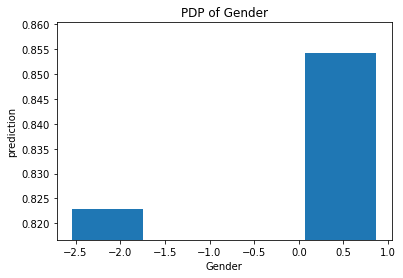

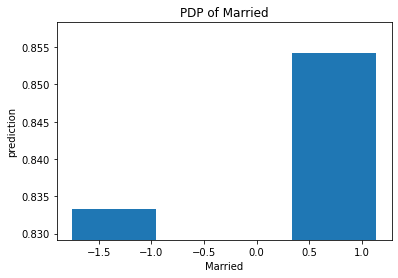

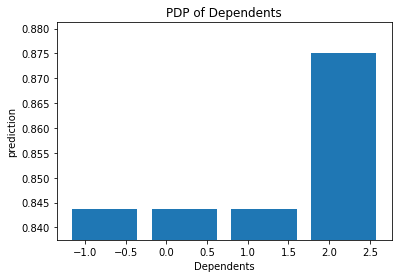

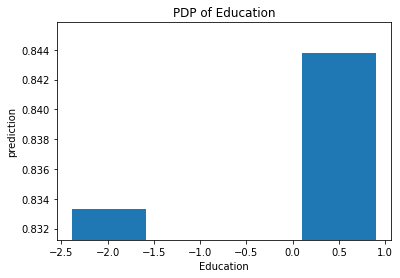

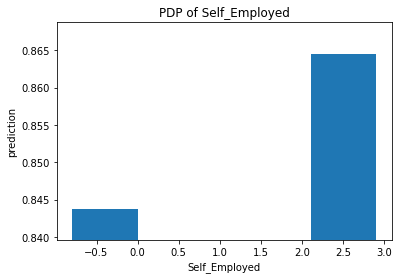

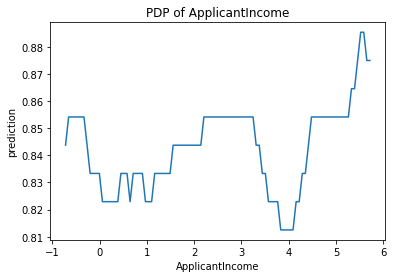

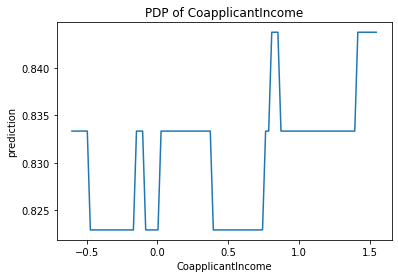

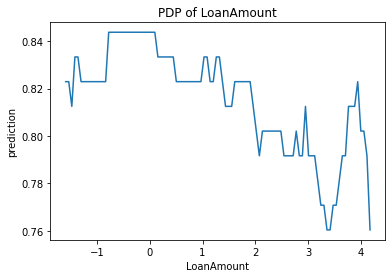

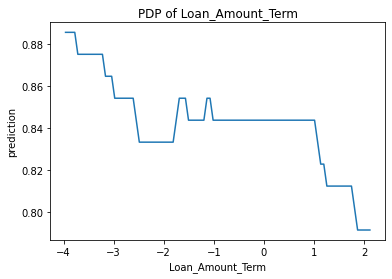

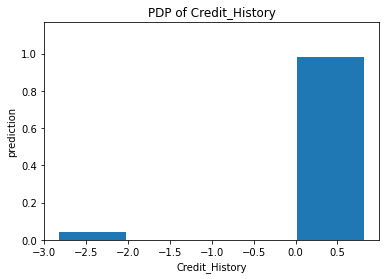

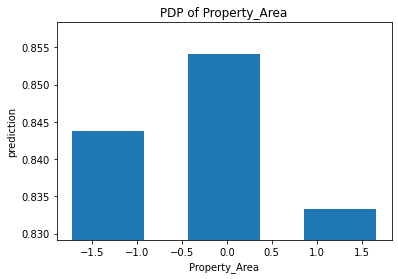

In [ ]:
for i in range(X_test.shape[1]):
    PDP(i, feature_names[i], model, X_test, y_test, categorical=categorical[i])
    plt.show()
    plt.close()

# Decision tree classifier

## Training model

In [ ]:
model_name = "decision tree classifier"
parameters = {'criterion': ('gini', 'entropy'), 'min_samples_split': np.arange(2, 307)}
tr = DecisionTreeClassifier(random_state=seed)

clf = find_best_model(tr, parameters, X_train, y_train)
print_errors(clf, model_name, X_test, y_test)

model = clf.best_estimator_
model

Balanced accuracy (decision tree classifier) = 0.7121212121212122
F1 = 0.8591549295774648
Accuracy = 0.7916666666666666
	class 0: 0.5
	class 1: 0.9242424242424242


DecisionTreeClassifier(criterion='entropy', min_samples_split=88,
                       random_state=3012)

## Intrinsic interpretability

<AxesSubplot:>

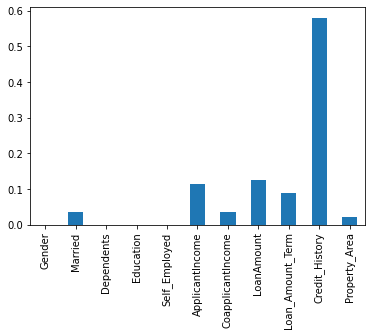

In [ ]:
model = clf.best_estimator_
model.feature_importances_
df = pd.Series(data=model.feature_importances_, index=feature_names)
df.plot.bar()

## Partial dependence plot

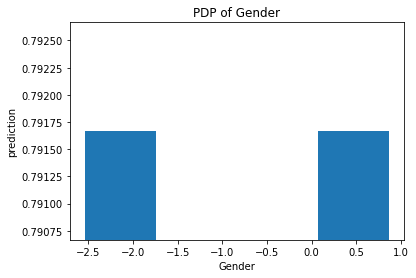

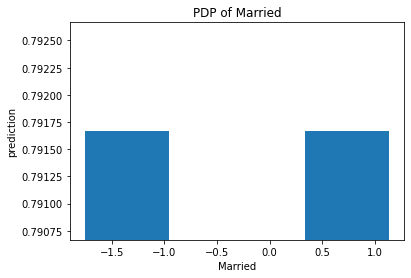

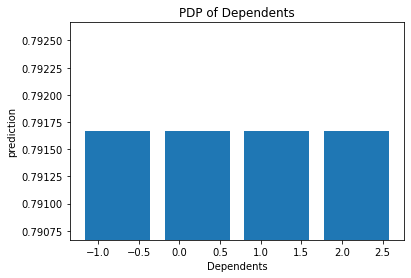

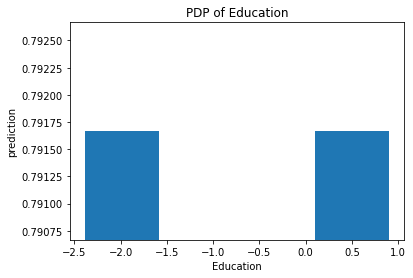

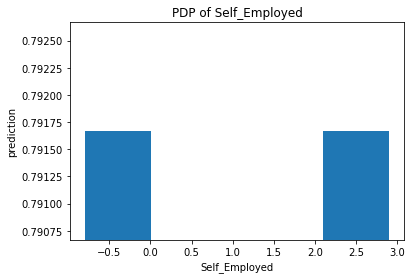

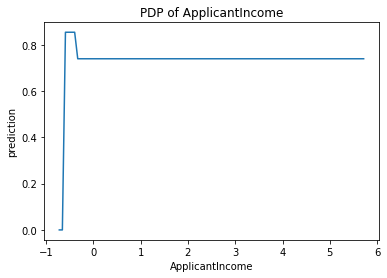

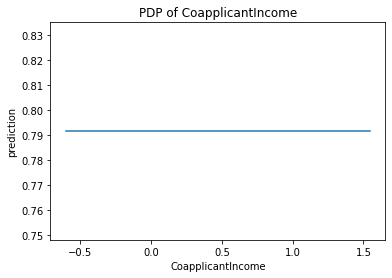

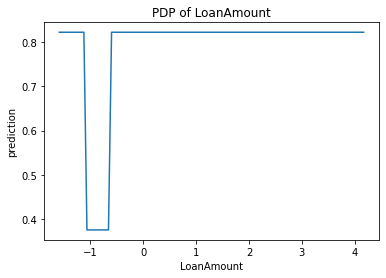

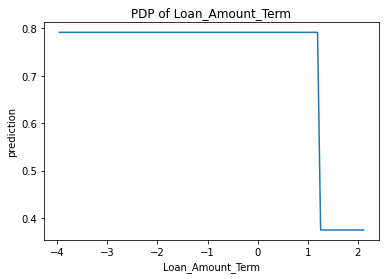

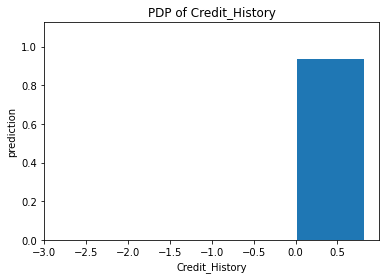

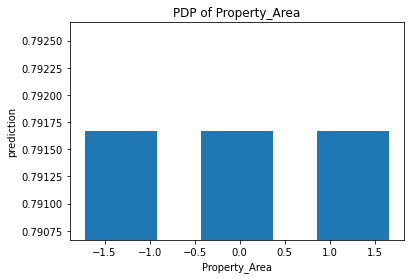

In [ ]:
for i in range(X_test.shape[1]):
    PDP(i, feature_names[i], model, X_test, y_test, categorical=categorical[i])
    plt.show()
    plt.close()

# Support vector classifier

## Training model

In [ ]:
model_name = "support vector classifier"
parameters = {'C': np.geomspace(0.0001, 100, 61)}
svc = SVC(kernel="linear")

clf = find_best_model(svc, parameters, X_train, y_train)
print_errors(clf, model_name, X_test, y_test)

model = clf.best_estimator_
model

Balanced accuracy (support vector classifier) = 0.7333333333333334
F1 = 0.8918918918918919
Accuracy = 0.8333333333333334
	class 0: 0.4666666666666667
	class 1: 1.0


SVC(C=0.005011872336272725, kernel='linear')

## Intrinsic interpretability

<AxesSubplot:>

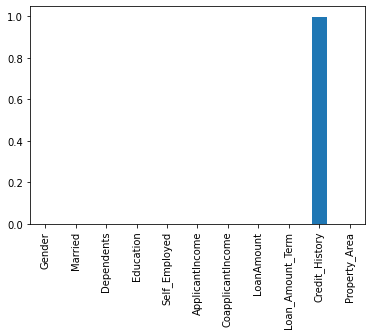

In [ ]:
df = pd.Series(data=np.abs(model.coef_[0]) / np.sum(np.abs(model.coef_[0])), index=feature_names)
df.plot.bar()

## Partial dependence plot

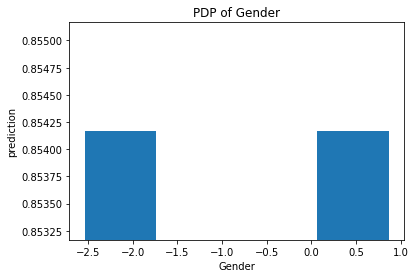

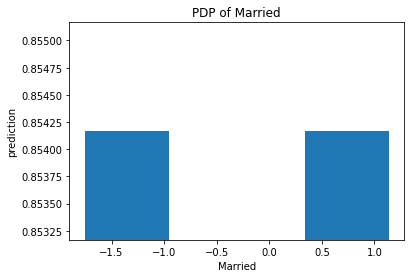

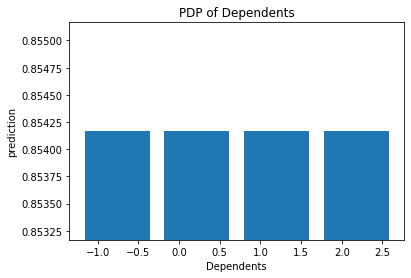

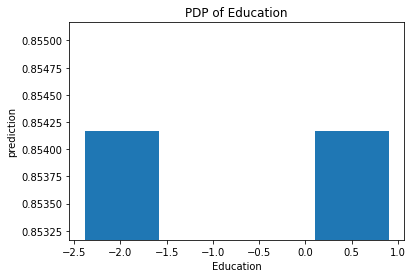

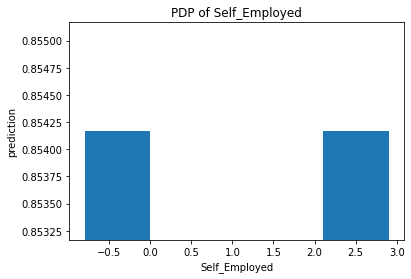

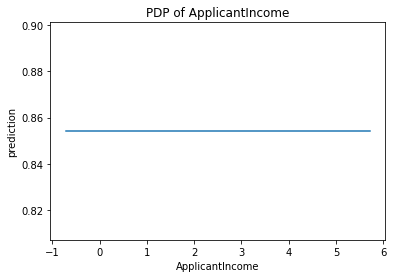

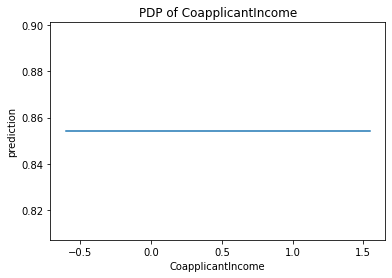

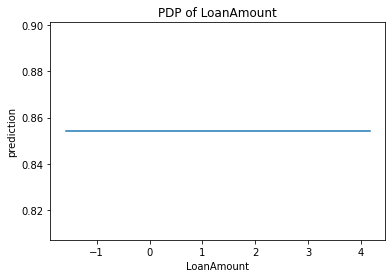

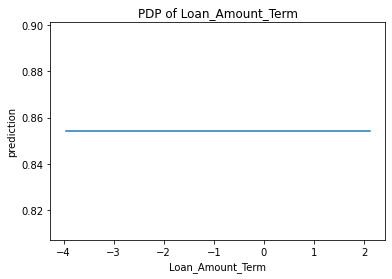

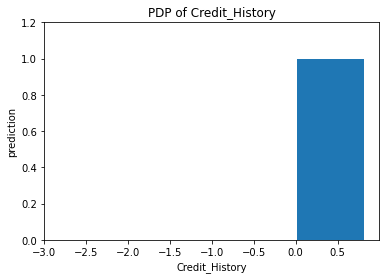

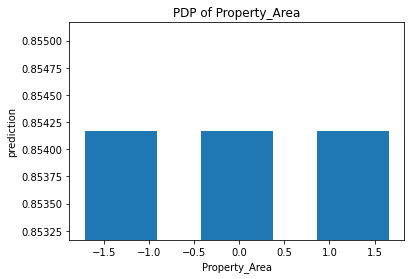

In [ ]:
categorical = [True, True, True, True, True, False, False, False, False, True, True]

for i in range(X_test.shape[1]):
    PDP(i, feature_names[i], model, X_test, y_test, categorical=categorical[i])
    plt.show()
    plt.close()

# Neural network

## Training model

In [ ]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.2, random_state=seed, stratify=y_)

In [ ]:
# Initialise neural network
BATCH_SIZE= 64
INPUT_SIZE= X_train.shape[1]

set_seed(seed)

model = Sequential()
model.add(Input(INPUT_SIZE))
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(10, activation="relu"))
model.add(Dropout(0.1))
# model.add(Dense(5, activation="relu"))
# model.add(Dropout(0.1))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam',
                loss="binary_crossentropy",
                metrics='binary_accuracy')

n_epochs = 86
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=n_epochs, validation_data=(X_val, y_val)) # validation_split=0.2)

Epoch 1/86
5/5 [==============================] - 1s 57ms/step - loss: 0.7063 - binary_accuracy: 0.6388 - val_loss: 0.7429 - val_binary_accuracy: 0.5844
Epoch 2/86
5/5 [==============================] - 0s 15ms/step - loss: 0.7092 - binary_accuracy: 0.6186 - val_loss: 0.7333 - val_binary_accuracy: 0.5844
Epoch 3/86
5/5 [==============================] - 0s 14ms/step - loss: 0.6833 - binary_accuracy: 0.6453 - val_loss: 0.7242 - val_binary_accuracy: 0.6234
Epoch 4/86
5/5 [==============================] - 0s 15ms/step - loss: 0.7078 - binary_accuracy: 0.6132 - val_loss: 0.7154 - val_binary_accuracy: 0.6494
Epoch 5/86
5/5 [==============================] - 0s 17ms/step - loss: 0.6848 - binary_accuracy: 0.6666 - val_loss: 0.7072 - val_binary_accuracy: 0.6494
Epoch 6/86
5/5 [==============================] - 0s 14ms/step - loss: 0.6751 - binary_accuracy: 0.6853 - val_loss: 0.6992 - val_binary_accuracy: 0.6494
Epoch 7/86
5/5 [==============================] - 0s 15ms/step - loss: 0.6592 - bi

    for key in history.history.keys():
        plt.plot(np.arange(1, n_epochs+1), history.history[key], label=key)
    plt.legend()
    plt.show()

    print(np.argmin(history.history['val_loss']))
    print(np.where(history.history['val_loss'] == np.min(history.history['val_loss'])))

In [ ]:
model_name = "Neural network"
print_errors(model, model_name, X_test, y_test)

Balanced accuracy (Neural network) = 0.7424242424242424
F1 = 0.8904109589041096
Accuracy = 0.8333333333333334
	class 0: 0.5
	class 1: 0.9848484848484849


## Partial dependence plot

In [ ]:
categorical = [True, True, True, True, True, False, False, False, False, True, True]

for i in range(X_test.shape[1]):
    _, _ = PDP(i, feature_names[i], model, X_test, y_test, categorical=categorical[i])
    plt.show()
    plt.close()

NameError: name 'classify' is not defined

Smoother plots if we use probabilities

## SHAP

In [ ]:
def classify_shap(X):
    output = model.predict(X)
    output = np.reshape(output, X.shape[0])
    return (output > 0.5).astype(int)

In [ ]:
import shap

X_test_df = pd.DataFrame(X_test, columns=feature_names)

explainer = shap.KernelExplainer(classify_shap, X_)
shap_test = explainer.shap_values(X_test_df[-10:])

Using 384 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/10 [00:00<?, ?it/s]

[ 0.46719815  0.73716237 -0.76203265  0.50325312 -0.3992747  -0.51908386
  0.29021677 -0.02157827  0.27554157  0.41319694 -0.02954695]
[0.01954139 0.01735782 0.01822114 0.00891862 0.00634093 0.00627669
 0.01295667 0.02312238 0.00404206 0.34319205 0.00381728]


<AxesSubplot:>

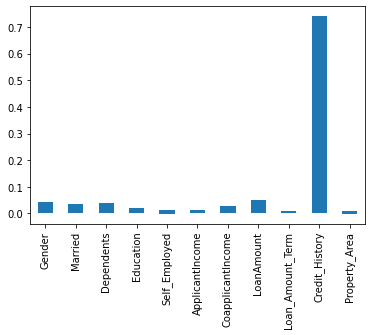

In [ ]:
y_mean = np.mean(classify(model.predict(X_train)))

k = 9

arg_sort = np.argsort(- np.abs(shap_test[k]))

df = pd.Series(shap_test[k], index=feature_names)

df.plot.bar()
print(X_test[-10+k])
print(np.mean(np.abs(shap_test), axis=0))

df2 = pd.Series(np.mean(np.abs(shap_test), axis=0) / np.sum(np.mean(np.abs(shap_test), axis=0)), index=feature_names)
df2.plot.bar()


In [ ]:
shap.force_plot(y_mean, shap_test[2], X_test_df.iloc[2,:])

In [ ]:
X_test_df.iloc[0,:]

Gender               0.467198
Married             -1.356553
Dependents          -0.762033
Education            0.503253
Self_Employed       -0.399275
ApplicantIncome     -0.447029
CoapplicantIncome    0.105511
LoanAmount          -0.232957
Loan_Amount_Term     0.275542
Credit_History       0.413197
Property_Area       -1.318868
Name: 0, dtype: float64

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5161fece-8ef6-4825-9ea6-16ebba884483' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>